In [1]:
!pip install langchain langchain_core langchain_groq langchain_community langchain langgraph


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.2/122.2 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00


In [2]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

Define Agent

In [3]:
class PlannerState(TypedDict):
  messages : Annotated[List[HumanMessage | AIMessage], "the messages in the conversation"]
  city: str
  interests: List[str]
  itinerary: str

In [4]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    temperature = 0,
    groq_api_key = "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",
    model_name = "llama-3.3-70b-versatile"
)


In [5]:
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my day trip."),
])

Define Agent Function

In [26]:
def process_inputs(state: PlannerState) -> PlannerState:
    """Collects user input for the city, interests, and duration of the trip."""
    print("Please enter the city you want to visit for your trip: ")
    city_input = input("Your Input: ")

    print(f"Please enter your interests for the trip to {city_input} (comma-separated): ")
    interests_input = input("Your Input: ")

    print("How many days will your trip last? (Enter a number): ")
    days_input = int(input("Your Input: "))

    return {
        **state,
        "city": city_input,
        "interests": [interest.strip() for interest in interests_input.split(",")],
        "days": days_input,
        "messages": state["messages"] + [
            HumanMessage(content=f"City: {city_input}"),
            HumanMessage(content=f"Interests: {interests_input}"),
            HumanMessage(content=f"Days: {days_input}"),
        ]
    }

def generate_itinerary(state: PlannerState) -> PlannerState:
    """Generates an itinerary based on user inputs."""
    print(f"Creating an itinerary for {state['city']} based on interests: {', '.join(state['interests'])}")

    response = llm.invoke(itinerary_prompt.format_messages(
        city=state["city"],
        interests=", ".join(state["interests"]),
        days=state["days"]
    ))

    print("\n📌 Final Itinerary:\n")
    print(response.content)

    return {
        **state,
        "itinerary": response.content,
        "messages": state["messages"] + [AIMessage(content=response.content)],
    }

def fetch_city_image(state: PlannerState) -> PlannerState:
    """Fetches an image of the city from the Unsplash API."""
    print(f"Fetching an image for {state['city']}...")

    url = f"https://api.unsplash.com/search/photos?query={state['city']}&client_id={UNSPLASH_ACCESS_KEY}"
    response = requests.get(url).json()

    image_url = response["results"][0]["urls"]["regular"] if response["results"] else None
    return {**state, "image_url": image_url}

def generate_maps_link(state: PlannerState) -> PlannerState:
    """Generates a Google Maps link for the city."""
    maps_link = f"https://www.google.com/maps/search/{state['city']}"
    print(f"Google Maps Link: {maps_link}")
    return {**state, "maps_link": maps_link}

def format_itinerary(state: PlannerState) -> PlannerState:
    """Formats the itinerary for better readability."""
    formatted_itinerary = markdown2.markdown(f"### 🗺️ Your Travel Itinerary\n\n{state['itinerary']}")
    return {**state, "itinerary": formatted_itinerary}


Create and Compile the Graph

In [27]:
workflow = StateGraph(PlannerState)

# Adding Nodes
workflow.add_node("process_inputs", process_inputs)
workflow.add_node("generate_itinerary", generate_itinerary)
workflow.add_node("fetch_city_image", fetch_city_image)
workflow.add_node("generate_maps_link", generate_maps_link)
workflow.add_node("format_itinerary", format_itinerary)

# Setting Entry Point
workflow.set_entry_point("process_inputs")

# Defining Edges (Workflow Steps)
workflow.add_edge("process_inputs", "generate_itinerary")
workflow.add_edge("generate_itinerary", "fetch_city_image")
workflow.add_edge("fetch_city_image", "generate_maps_link")
workflow.add_edge("generate_maps_link", "format_itinerary")
workflow.add_edge("format_itinerary", END)

# Compile the Workflow
app = workflow.compile()


Display the graph structure

In [31]:
!apt-get install graphviz
!pip install graphviz


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


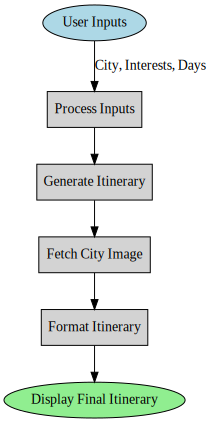

In [34]:
from graphviz import Digraph

def display_workflow_graph():
    dot = Digraph(comment="AI Travel Planner Workflow")

    # Define Nodes
    dot.node("A", "User Inputs", shape="oval", style="filled", fillcolor="lightblue")
    dot.node("B", "Process Inputs", shape="box", style="filled", fillcolor="lightgray")
    dot.node("C", "Generate Itinerary", shape="box", style="filled", fillcolor="lightgray")
    dot.node("D", "Fetch City Image", shape="box", style="filled", fillcolor="lightgray")
    dot.node("E", "Format Itinerary", shape="box", style="filled", fillcolor="lightgray")
    dot.node("F", "Display Final Itinerary", shape="oval", style="filled", fillcolor="lightgreen")

    # Define Edges (Connections)
    dot.edge("A", "B", label="City, Interests, Days")
    dot.edge("B", "C")
    dot.edge("C", "D")
    dot.edge("D", "E")
    dot.edge("E", "F")

    # Render Graph
    return dot

# Display the graph
display_workflow_graph()


Define the function thats runs the graph

In [9]:
def travel_planner(user_request: str):
  print(f"Initial Request: {user_request}\n")
  state = {
      "messages": [HumanMessage(content=user_request)],
      "city": "",
      "interests": [],
      "itinerary": "",
  }
  for output in app.stream(state):
    pass

In [10]:
user_request = "I want to plan a day trip"
travel_planner(user_request)

Initial Request: I want to plan a day trip

Please enter the city you want to visit for your day trip: 
Your Input: kolkata
Please enter your interest for the trip to : kolkata (comma-separted): 
Your Input: newtown
Creating an itinerary for kolkata based on interests : newtown

Final Itinerary: 
For a day trip to Newtown, Kolkata, here's a brief itinerary based on popular interests:

* 9:00 AM - 10:00 AM: Start the day with breakfast at a local café in Newtown, such as Cafe Coffee Day or The Coffee Bean & Tea Leaf.
* 10:00 AM - 12:00 PM: Visit the Mother's Wax Museum, a unique attraction featuring wax statues of famous personalities.
* 12:00 PM - 1:30 PM: Head to the Eco Park, a large urban park with a variety of activities, including boating, cycling, and walking trails.
* 1:30 PM - 3:00 PM: Take a break for lunch at one of the many restaurants in Newtown, such as Oh! Calcutta or 6 Ballygunge Place.
* 3:00 PM - 5:00 PM: Explore the Axis Mall or City Centre II, two popular shopping ma

In [11]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
to

In [14]:
!pip install markdown2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 1.5 MB/s eta 0:00:00


In [33]:
import gradio as gr
import requests
import json
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
import markdown2

# API Key for City Images (Replace with your Unsplash key)
UNSPLASH_ACCESS_KEY = ""

class PlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "Conversation history"]
    city: str
    interests: List[str]
    days: int
    itinerary: str

# Define LLM
llm = ChatGroq(
    temperature=0,
    groq_api_key="",
    model_name="llama-3.3-70b-versatile"
)

# Improved Itinerary Prompt
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a smart travel planner. Create a {days}-day itinerary for {city} based on {interests}. "
               "Consider weather, budget, and must-see places. Use short bullet points."),
    ("human", "Generate my itinerary."),
])

# Fetch city image from Unsplash
def get_city_image(city):
    url = f"https://api.unsplash.com/search/photos?query={city}&client_id={UNSPLASH_ACCESS_KEY}"
    response = requests.get(url).json()
    if response["results"]:
        return response["results"][0]["urls"]["regular"]
    return None

# Process user inputs
def input_city(city: str, state: PlannerState) -> PlannerState:
    return {**state, "city": city, "messages": state['messages'] + [HumanMessage(content=city)]}

def input_interests(interests: List[str], state: PlannerState) -> PlannerState:
    return {**state, "interests": interests, "messages": state['messages'] + [HumanMessage(content=", ".join(interests))]}

def input_days(days: int, state: PlannerState) -> PlannerState:
    return {**state, "days": days}

# Generate the itinerary
def create_itinerary(state: PlannerState) -> str:
    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], interests=", ".join(state['interests']), days=state['days']))
    state["itinerary"] = response.content
    state["messages"] += [AIMessage(content=response.content)]
    return response.content

# Convert itinerary to Markdown for better formatting
def format_itinerary(itinerary: str) -> str:
    return markdown2.markdown(f"### Your Travel Itinerary 🗺️\n{itinerary}")

# Generate Google Maps search link
def generate_maps_link(city):
    return f"[📍 Explore {city} on Google Maps](https://www.google.com/maps/search/{city})"

# Main function
def travel_planner(city: str, interests: List[str], days: int):
    state = {
        "messages": [],
        "city": "",
        "interests": [],
        "days": 1,
        "itinerary": "",
    }

    # Process inputs
    state = input_city(city, state)
    state = input_interests(interests, state)
    state = input_days(days, state)

    # Generate itinerary
    itinerary = create_itinerary(state)
    formatted_itinerary = format_itinerary(itinerary)

    # Fetch city image
    city_image = get_city_image(city)

    # Google Maps link
    maps_link = generate_maps_link(city)

    return formatted_itinerary, city_image, maps_link

# Gradio Interface with Improved UI
interface = gr.Interface(
    fn=travel_planner,
    inputs=[
        gr.Textbox(label="Enter City"),
        gr.CheckboxGroup(["Museums", "Beaches", "Food", "Music", "Hiking","Clubs","Hotels"], label="Select Your Interests"),
        gr.Slider(minimum=1, maximum=7, step=1, label="Trip Duration (Days)"),
    ],
    outputs=[
        gr.Markdown(label="Generated Itinerary"),
        gr.Image(label="City Image"),
        gr.Markdown(label="Google Maps Link"),
    ],
    title="🌍 AI Travel Maestro",
    description="Discover your ideal adventure with AI-crafted, personalized travel plans tailored just for you!",
    theme="soft",
    css="""
        body { background-color: #FFFFFF; color: #333333; }
        .gradio-container {
            background-color: #F9F9F9;
            border-radius: 10px;
            padding: 20px;
            box-shadow: 0px 4px 10px rgba(0, 0, 0, 0.1);
        }
        input, select, textarea {
            border: 2px solid #6C63FF;
            background-color: #FFFFFF;
            color: #333333;
            border-radius: 8px;
            padding: 10px;
            font-size: 14px;
        }
        .output {
            border: 2px solid #FF6584;
            background-color: #FFFFFF;
            color: #333333;
            border-radius: 8px;
            padding: 10px;
        }
        h1, h2, h3, p { color: #6C63FF; }
        button {
            background-color: #6C63FF;
            color: white;
            border-radius: 8px;
            padding: 10px 15px;
            font-size: 16px;
            border: none;
            transition: 0.3s;
        }
        button:hover { background-color: #4B49AC; }
    """
)

interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7b27497453709dd748.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
